In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import control
import random
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

/Users/chyj528/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Graph Setting

In [15]:
def generate_sets(l, m):
    numbers = list(range(16))
    
    O = sorted(numbers[-l:], reverse=True)
    M = numbers[:m]
    
    return O, M

def generate_B(n, m, M):
    B = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            if i == M[j]:
                B[i][j] = 1
    return B

def generate_C(n, l, O):
    C = np.zeros((l,n))
    for j in range(l):
        for i in range(n):
            if i == O[j]:
                C[j][i] = 1
    return C

def weighted_matrix(n):
    #sign = np.random.choice([-1,1],size = (n,n))
    sign = np.ones((n, n), dtype=int)
    W = np.multiply(sign,np.random.randint(low = 1, high = 5, size = (n,n)))
    return W

def plot_adjacency_matrix(matrix):
    plt.rcParams.update({'font.family': 'Helvetica', 'font.size': 14})  # Set the font and size
    
    fig, ax = plt.subplots()
    cmap = plt.cm.get_cmap('binary', 2)  # Create a custom colormap with 2 colors (black and red)
    cmap.set_over('red')  # Set the second color in the colormap to red

    cax = ax.matshow(matrix, cmap=cmap, vmin=0, vmax=1.1)  # Set the range of values for the colormap

    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i, j] == 1:
                ax.text(j, i, matrix[i, j], ha='center', va='center', color='white', fontsize=12)

    # Set all x and y ticks
    ax.set_xticks(range(matrix.shape[1]))
    ax.set_yticks(range(matrix.shape[0]))
    ax.set_xticklabels(range(matrix.shape[1]), fontsize=10)
    ax.set_yticklabels(range(matrix.shape[0]), fontsize=10)
    
    # Set labels and title
    plt.xlabel('Nodes', fontsize=12, labelpad=10)
    plt.ylabel('Nodes', fontsize=12)
    #plt.title('Adjacency Matrix', fontsize=18)
    
    # Add a colorbar
    #cbar = plt.colorbar(cax, ticks=[0, 1], orientation='vertical', fraction=0.046, pad=0.04)
    #cbar.ax.set_yticklabels(['0', '1'], fontsize=12)

    # Save and display the figure
    plt.savefig('./marriage_adj', format='png', dpi=150)  # Save as a high-quality PDF
    plt.show()

## Data Synthesis

In [3]:
def data_synthesis(noise_level, n, l, m, G_truth):
    noise = noise_level * np.random.multivariate_normal(mean = np.zeros(l), cov = np.identity(l), size = m).reshape(l,m)
    tmp = np.identity(n)
    M = np.zeros((n-2, l, m))
    for i in range(n-2):
        tmp = tmp @ G_truth
        M[i] = C@tmp@B + noise
    M = torch.from_numpy(M).float()
    #G_truth = torch.from_numpy(G_truth).float()
    return M

## ADAM

In [4]:
class Model(nn.Module):
    def __init__(self, n, C, B, gamma):
        super().__init__()
        self.n = n
        self.C = torch.from_numpy(C).float()
        self.B = torch.from_numpy(B).float()
        self.G = nn.Parameter(torch.zeros(self.n, self.n), requires_grad=True)
        self.gamma = gamma

    def forward(self):
        # Make G symmetric by averaging it with its transpose
        G_symmetric = 0.5 * (self.G + self.G.transpose(0, 1))
        
        # Set diagonal elements to 0
        G_symmetric_no_diag = G_symmetric * (1 - torch.eye(self.n))
        
        output = torch.zeros((self.n - 2, self.C.shape[0], self.B.shape[1]))
        tmp = torch.eye(self.n)
        l = output.shape[0]
        for i in range(l):
            tmp = tmp @ G_symmetric_no_diag
            output[i] = self.C @ tmp @ self.B
        return output + self.gamma * torch.norm(G_symmetric_no_diag, p=1)
    
def adam(n, C, B, M, gamma):
    model = Model(n, C, B,gamma)
    criterion = nn.MSELoss(reduction='sum')
    #optimizer = optim.Adam(model.parameters(), lr=0.001)

    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    epoch = 20000
    for i in range(epoch):
        output = model.forward()
        output = output.view(output.shape[0], -1)
        M = M.view(M.shape[0], -1)

        loss = criterion(output, M)
        if i % 5000 == 0:
            print("Epoch: [{}/{}]\tLoss: {}".format(i, epoch, loss.detach().numpy()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    G_learn = model.G.cpu().detach().numpy()
    return G_learn

In [5]:
# class Model(nn.Module):
#     def __init__(self, n, C, B, gamma):
#         super().__init__()
#         self.n = n
#         self.C = torch.from_numpy(C).float()
#         self.B = torch.from_numpy(B).float()
#         self.G = nn.Parameter(torch.zeros(self.n, self.n), requires_grad=True)
#         self.gamma = gamma
#     def forward(self):
#         output = torch.zeros((self.n - 2, self.C.shape[0], self.B.shape[1]))
#         tmp = torch.eye(self.n)
#         l = output.shape[0]
#         for i in range(l):
#             tmp = tmp @ self.G
#             output[i] = self.C @ tmp @ self.B
#         return output + self.gamma*torch.norm(self.G, p=1)

# def adam(n, C, B, M, gamma):
#     model = Model(n, C, B,gamma)
#     criterion = nn.MSELoss(reduction='sum')
#     #optimizer = optim.Adam(model.parameters(), lr=0.001)

#     optimizer = optim.Adam(model.parameters(), lr=0.0001)

#     epoch = 50000
#     for i in range(epoch):
#         output = model.forward()
#         output = output.view(output.shape[0], -1)
#         M = M.view(M.shape[0], -1)

#         loss = criterion(output, M)
#         if i % 5000 == 0:
#             print("Epoch: [{}/{}]\tLoss: {}".format(i, epoch, loss.detach().numpy()))

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     G_learn = model.G.cpu().detach().numpy()
#     return G_learn

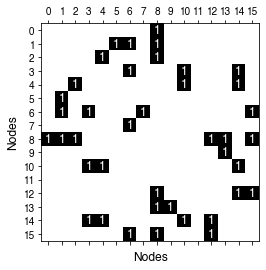

In [16]:
# Set Marraige Network

n = 16
A = np.array([[0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
    [0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0],
    [0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0],
    [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1],
    [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],
    [1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],
    [0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1],
    [0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0],
    [0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0],
    [0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0]])

W = weighted_matrix(n)
G = np.multiply(W,A)
spectral_radius = np.max([np.abs(i) for i in np.linalg.eigvals(G)])
G = G.T/(spectral_radius+0.01)
plot_adjacency_matrix(A)


## Traverse l and m

In [158]:
auc_roc_matrix = np.zeros((n-1,n-1))
for l in range(1,n):
    for m in range(1,n):
        print("Processing l = ",l," m = ",m,":")
        O, M = generate_sets(l, m)
        B = generate_B(n, m, M)
        C = generate_C(n, l, O)
        noise_level = 0
        G_truth = G
        M = data_synthesis(noise_level, n, l, m, G_truth)

        # ADAM
        gamma = 0.00005
        G_learn = adam(n, C, B, M, gamma)

        # Flatten the matrices
        A_flat = A.flatten()
        G_learn_flat = G_learn.flatten()

        # Calculate AUC-ROC score
        auc_roc = roc_auc_score(A_flat, G_learn_flat)
        auc_roc_matrix[l-1,m-1] = auc_roc
        print("AUC-ROC score:", auc_roc)

Processing l =  1  m =  1 :
Epoch: [0/20000]	Loss: 0.02385621890425682
Epoch: [5000/20000]	Loss: 0.02385621890425682
Epoch: [10000/20000]	Loss: 0.02385621890425682
Epoch: [15000/20000]	Loss: 0.02385621890425682
AUC-ROC score: 0.5
Processing l =  1  m =  2 :
Epoch: [0/20000]	Loss: 0.14359590411186218
Epoch: [5000/20000]	Loss: 0.14359590411186218
Epoch: [10000/20000]	Loss: 0.14359590411186218
Epoch: [15000/20000]	Loss: 0.14359590411186218
AUC-ROC score: 0.5
Processing l =  1  m =  3 :
Epoch: [0/20000]	Loss: 0.1525810956954956
Epoch: [5000/20000]	Loss: 0.1525810956954956
Epoch: [10000/20000]	Loss: 0.1525810956954956
Epoch: [15000/20000]	Loss: 0.1525810956954956
AUC-ROC score: 0.5
Processing l =  1  m =  4 :
Epoch: [0/20000]	Loss: 0.19269776344299316
Epoch: [5000/20000]	Loss: 0.19269776344299316
Epoch: [10000/20000]	Loss: 0.19269776344299316
Epoch: [15000/20000]	Loss: 0.19269776344299316
AUC-ROC score: 0.5
Processing l =  1  m =  5 :
Epoch: [0/20000]	Loss: 0.20244911313056946
Epoch: [5000/

Epoch: [5000/20000]	Loss: 0.4050370752811432
Epoch: [10000/20000]	Loss: 0.17607127130031586
Epoch: [15000/20000]	Loss: 0.1703546792268753
AUC-ROC score: 0.5201388888888889
Processing l =  3  m =  6 :
Epoch: [0/20000]	Loss: 1.4408782720565796
Epoch: [5000/20000]	Loss: 0.3746210038661957
Epoch: [10000/20000]	Loss: 0.21289822459220886
Epoch: [15000/20000]	Loss: 0.18232816457748413
AUC-ROC score: 0.55
Processing l =  3  m =  7 :
Epoch: [0/20000]	Loss: 2.138169288635254
Epoch: [5000/20000]	Loss: 0.1263965517282486
Epoch: [10000/20000]	Loss: 0.06955733150243759
Epoch: [15000/20000]	Loss: 0.06779473274946213
AUC-ROC score: 0.5703703703703703
Processing l =  3  m =  8 :
Epoch: [0/20000]	Loss: 2.3198347091674805
Epoch: [5000/20000]	Loss: 0.12770351767539978
Epoch: [10000/20000]	Loss: 0.08484836667776108
Epoch: [15000/20000]	Loss: 0.08234871178865433
AUC-ROC score: 0.6555555555555556
Processing l =  3  m =  9 :
Epoch: [0/20000]	Loss: 3.206888198852539
Epoch: [5000/20000]	Loss: 0.1294041424989700

Epoch: [15000/20000]	Loss: 0.045381851494312286
AUC-ROC score: 0.8550925925925926
Processing l =  5  m =  10 :
Epoch: [0/20000]	Loss: 4.189676284790039
Epoch: [5000/20000]	Loss: 0.08853674679994583
Epoch: [10000/20000]	Loss: 0.04631572589278221
Epoch: [15000/20000]	Loss: 0.046119559556245804
AUC-ROC score: 0.8763888888888889
Processing l =  5  m =  11 :
Epoch: [0/20000]	Loss: 4.687536716461182
Epoch: [5000/20000]	Loss: 0.07236179709434509
Epoch: [10000/20000]	Loss: 0.04711716249585152
Epoch: [15000/20000]	Loss: 0.04684773087501526
AUC-ROC score: 0.9944444444444445
Processing l =  5  m =  12 :
Epoch: [0/20000]	Loss: 4.687536239624023
Epoch: [5000/20000]	Loss: 0.07227254658937454
Epoch: [10000/20000]	Loss: 0.04716208577156067
Epoch: [15000/20000]	Loss: 0.046861547976732254
AUC-ROC score: 0.9949074074074074
Processing l =  5  m =  13 :
Epoch: [0/20000]	Loss: 5.595783710479736
Epoch: [5000/20000]	Loss: 0.1051173061132431
Epoch: [10000/20000]	Loss: 0.060822851955890656
Epoch: [15000/20000]	

Epoch: [5000/20000]	Loss: 0.4371245801448822
Epoch: [10000/20000]	Loss: 0.36593231558799744
Epoch: [15000/20000]	Loss: 0.36563587188720703
AUC-ROC score: 0.9995370370370371
Processing l =  7  m =  15 :
Epoch: [0/20000]	Loss: 12.16299057006836
Epoch: [5000/20000]	Loss: 0.6400125026702881
Epoch: [10000/20000]	Loss: 0.558462917804718
Epoch: [15000/20000]	Loss: 0.558061957359314
AUC-ROC score: 1.0
Processing l =  8  m =  1 :
Epoch: [0/20000]	Loss: 0.19825857877731323
Epoch: [5000/20000]	Loss: 0.008199426345527172
Epoch: [10000/20000]	Loss: 0.002429113257676363
Epoch: [15000/20000]	Loss: 0.0021071280352771282
AUC-ROC score: 0.6277777777777777
Processing l =  8  m =  2 :
Epoch: [0/20000]	Loss: 1.0901471376419067
Epoch: [5000/20000]	Loss: 0.0900425836443901
Epoch: [10000/20000]	Loss: 0.03865952417254448
Epoch: [15000/20000]	Loss: 0.033049654215574265
AUC-ROC score: 0.6050925925925927
Processing l =  8  m =  3 :
Epoch: [0/20000]	Loss: 1.2047160863876343
Epoch: [5000/20000]	Loss: 0.084157645702

Epoch: [10000/20000]	Loss: 0.02588696777820587
Epoch: [15000/20000]	Loss: 0.0251974705606699
AUC-ROC score: 0.7784722222222222
Processing l =  10  m =  4 :
Epoch: [0/20000]	Loss: 3.602327823638916
Epoch: [5000/20000]	Loss: 0.12981195747852325
Epoch: [10000/20000]	Loss: 0.062456876039505005
Epoch: [15000/20000]	Loss: 0.060983531177043915
AUC-ROC score: 0.8657407407407407
Processing l =  10  m =  5 :
Epoch: [0/20000]	Loss: 4.073952674865723
Epoch: [5000/20000]	Loss: 0.11859912425279617
Epoch: [10000/20000]	Loss: 0.06509251892566681
Epoch: [15000/20000]	Loss: 0.06489869952201843
AUC-ROC score: 0.9652777777777778
Processing l =  10  m =  6 :
Epoch: [0/20000]	Loss: 4.151623725891113
Epoch: [5000/20000]	Loss: 0.10833293944597244
Epoch: [10000/20000]	Loss: 0.06043517217040062
Epoch: [15000/20000]	Loss: 0.060324981808662415
AUC-ROC score: 0.9893518518518518
Processing l =  10  m =  7 :
Epoch: [0/20000]	Loss: 6.101574420928955
Epoch: [5000/20000]	Loss: 0.27501338720321655
Epoch: [10000/20000]	L

AUC-ROC score: 0.9208333333333334
Processing l =  12  m =  8 :
Epoch: [0/20000]	Loss: 7.446384429931641
Epoch: [5000/20000]	Loss: 0.5009332895278931
Epoch: [10000/20000]	Loss: 0.4715282618999481
Epoch: [15000/20000]	Loss: 0.4713306427001953
AUC-ROC score: 0.975
Processing l =  12  m =  9 :
Epoch: [0/20000]	Loss: 9.672774314880371
Epoch: [5000/20000]	Loss: 0.5556085109710693
Epoch: [10000/20000]	Loss: 0.5284413695335388
Epoch: [15000/20000]	Loss: 0.527755618095398
AUC-ROC score: 0.9851851851851852
Processing l =  12  m =  10 :
Epoch: [0/20000]	Loss: 9.935794830322266
Epoch: [5000/20000]	Loss: 0.5597038269042969
Epoch: [10000/20000]	Loss: 0.5369591116905212
Epoch: [15000/20000]	Loss: 0.5367288589477539
AUC-ROC score: 0.9888888888888889
Processing l =  12  m =  11 :
Epoch: [0/20000]	Loss: 11.044492721557617
Epoch: [5000/20000]	Loss: 1.030776023864746
Epoch: [10000/20000]	Loss: 0.9778755903244019
Epoch: [15000/20000]	Loss: 0.9778754115104675
AUC-ROC score: 1.0
Processing l =  12  m =  12 :

Epoch: [10000/20000]	Loss: 1.4193905591964722
Epoch: [15000/20000]	Loss: 1.4193918704986572
AUC-ROC score: 1.0
Processing l =  14  m =  13 :
Epoch: [0/20000]	Loss: 16.75237274169922
Epoch: [5000/20000]	Loss: 1.6424039602279663
Epoch: [10000/20000]	Loss: 1.5738670825958252
Epoch: [15000/20000]	Loss: 1.5738670825958252
AUC-ROC score: 1.0
Processing l =  14  m =  14 :
Epoch: [0/20000]	Loss: 17.54793930053711
Epoch: [5000/20000]	Loss: 1.6804295778274536
Epoch: [10000/20000]	Loss: 1.6113601922988892
Epoch: [15000/20000]	Loss: 1.61135995388031
AUC-ROC score: 1.0
Processing l =  14  m =  15 :
Epoch: [0/20000]	Loss: 21.40375518798828
Epoch: [5000/20000]	Loss: 2.0279438495635986
Epoch: [10000/20000]	Loss: 1.9454097747802734
Epoch: [15000/20000]	Loss: 1.9454097747802734
AUC-ROC score: 1.0
Processing l =  15  m =  1 :
Epoch: [0/20000]	Loss: 0.28710371255874634
Epoch: [5000/20000]	Loss: 0.0029093055054545403
Epoch: [10000/20000]	Loss: 0.0017175759421661496
Epoch: [15000/20000]	Loss: 0.001665473566

In [39]:
# Generate Data
M = [1,3,5,7,9,11,13,15]
O = [0,2,4,6,8,10,12,14]
l, m = len(O), len(M)
B = generate_B(n, m, M)
C = generate_C(n, l, O)
noise_level = 0
G_truth = G
M = data_synthesis(noise_level, n, l, m, G_truth)

# ADAM
gamma = 0.000001
G_learn = adam(n, C, B, M, gamma)

Epoch: [0/20000]	Loss: 6.834207534790039
Epoch: [5000/20000]	Loss: 0.24490448832511902
Epoch: [10000/20000]	Loss: 0.16182594001293182
Epoch: [15000/20000]	Loss: 0.1610429883003235


In [40]:
# Flatten the matrices
A_flat = A.flatten()
G_learn_flat = G_learn.flatten()

# Calculate AUC-ROC score
auc_roc = roc_auc_score(A_flat, G_learn_flat)

print("AUC-ROC score:", auc_roc)

AUC-ROC score: 0.9976851851851852


In [41]:
relative_error = np.linalg.norm(G_truth-G_learn,'fro')/np.linalg.norm(G_truth,'fro')
relative_error

0.4626014094842324

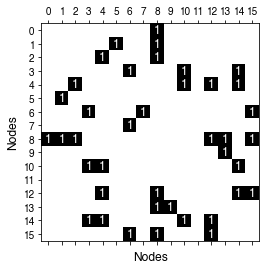

In [42]:
# Number of large entries to set as 1
n_large = 40

# Flatten the matrix
G_learn_flat = G_learn.flatten()

# Find the indices of the n_large largest entries
largest_indices = np.argpartition(G_learn_flat, -n_large)[-n_large:]

# Set the first n_large largest entries as 1 and others as 0
G_learn_flat_binary = np.zeros_like(G_learn_flat)
G_learn_flat_binary[largest_indices] = 1

# Reshape the flattened binary matrix back to its original shape
G_learn_binary = G_learn_flat_binary.reshape(G_learn.shape)

G_learn_binary = G_learn_binary.astype(int)

# print("Binary G_learn matrix:")
# print(G_learn_binary)

plot_adjacency_matrix(G_learn_binary)

In [43]:
G_learn_binary - A

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

In [44]:
def flatten_upper_triangle(matrix):
    return [matrix[i][j] for i in range(len(matrix)) for j in range(i + 1, len(matrix[i]))]

# Example usage
matrix = [
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
]

result = flatten_upper_triangle(matrix)
print(result)


[2, 3, 6]


[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 1 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 2 0 0 0 2 0]
 [0 0 2 0 0 0 0 0 0 0 2 0 3 0 2 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 2 0 0 0 2 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [2 2 2 0 0 0 0 0 0 0 0 0 2 2 0 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 2 2 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 2

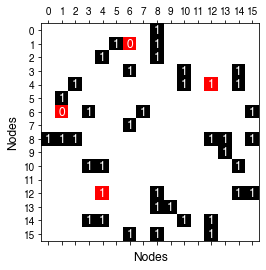

In [45]:
from matplotlib.colors import ListedColormap

def plot_matrix_diff(A, G_learn_binary):
    plt.rcParams.update({'font.family': 'Helvetica', 'font.size': 14})  # Set the font and size
    
    fig, ax = plt.subplots()
    cmap = ListedColormap(['white','red','black', 'red'])  # Create a custom colormap with 3 colors (white, black, and red)
#     cmap.set_under('white')  # Set the first color in the colormap to white
#     cmap.set_bad('black')  # Set the second color in the colormap to black
#     cmap.set_over('red')  # Set the third color in the colormap to red

    # Create a new matrix with 1s at the positions where A and G_learn_binary differ and 0s elsewhere
    diff = np.not_equal(A, G_learn_binary).astype(int)
    
    print(diff)
    # Combine the diff and G_learn_binary matrices to plot
    combined_matrix = G_learn_binary * 2 + diff

    print(combined_matrix)
    
    cax = ax.matshow(combined_matrix, cmap=cmap, vmin=0.1, vmax=3)  # Set the range of values for the colormap

    for i in range(combined_matrix.shape[0]):
        for j in range(combined_matrix.shape[1]):
            if combined_matrix[i, j] > 0:
                color = 'white' #if diff[i, j] else 'black'
                
                ax.text(j, i, G_learn_binary[i, j], ha='center', va='center', color=color, fontsize=12)

    # Set all x and y ticks
    ax.set_xticks(range(combined_matrix.shape[1]))
    ax.set_yticks(range(combined_matrix.shape[0]))
    ax.set_xticklabels(range(combined_matrix.shape[1]), fontsize=10)
    ax.set_yticklabels(range(combined_matrix.shape[0]), fontsize=10)
    
    # Set labels and title
    plt.xlabel('Nodes', fontsize=12, labelpad=10)
    plt.ylabel('Nodes', fontsize=12)
    
    # Save and display the figure
    plt.savefig('./predicted_adj', format='png', dpi=150)  # Save as a high-quality PDF
    plt.show()
    
plot_matrix_diff(A, G_learn_binary)


In [159]:
import numpy as np
import pandas as pd

# # Create a matrix using NumPy
# matrix = np.array([[1, 2, 3],
#                    [4, 5, 6],
#                    [7, 8, 9]])

# Convert the NumPy array to a pandas DataFrame
df = pd.DataFrame(auc_roc_matrix)

# Save the DataFrame as a CSV file
df.to_csv('auc_roc_matrix.csv', index=False, header=False)


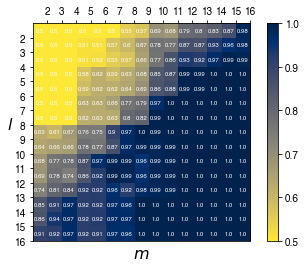

In [220]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def plot_auc_roc_matrix(matrix):
    plt.rcParams.update({'font.family': 'Helvetica', 'font.size': 10})  # Set the font and size
    
    fig, ax = plt.subplots()
    
    # Create a custom continuous colormap from yellow to blue
    cmap = plt.get_cmap('cividis_r')
    extent = [0, matrix.shape[1], 0, matrix.shape[0]]
    
    cax = ax.imshow(matrix, cmap=cmap, aspect='equal', extent=extent)

    # Display the matrix entries
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(j + 0.5, i + 0.5, round(matrix[14 - i, j], 2), ha='center', va='center', color='w', fontsize=6, fontweight='bold')

    # Set all x and y ticks
    ax.set_xticks(range(1,matrix.shape[1]+1))
    ax.set_yticks(range(matrix.shape[0]))
    ax.set_xticklabels(range(2, matrix.shape[0]+2), fontsize=10)  # Set xticks to be 2, 3, ..., 16
    ax.set_yticklabels(range(matrix.shape[1]+1, 1, -1), fontsize=10) 
    
    # Move xticks to the top
    ax.xaxis.tick_top()
    
    # Set labels and title
    plt.xlabel(r'$m$', fontsize=16, labelpad=5) 
    plt.ylabel(r'$l$', fontsize=16, rotation=0)
    
    # Add a colorbar
    cbar = plt.colorbar(cax, orientation='vertical', fraction=0.04)
    #cbar.set_label('Color scale', fontsize=12)

    # Save and display the figure
    plt.savefig('./figs/auc_matrix.jpg', format='jpg', dpi=300)  # Save as a high-quality JPG
    plt.show()

plot_auc_roc_matrix(auc_roc_matrix)
